In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from treeinterpreter import treeinterpreter as ti
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
from sklearn.svm import SVR 
from sklearn.preprocessing import MinMaxScaler

In [2]:
# master_df = pd.DataFrame()
# set columns script, "", "", train_p, "", test_p, "", "", mse, rmse, mae, mape, "", cross_correlation
master_df = pd.DataFrame(columns=['script', '', '', 'train_p', '', 'test_p', '', '', 'mse', 'rmse', 'mae', 'mape', '', 'cross_correlation'])
all_title = 'score'

### Cross Correlation function for future use

In [3]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

In [4]:
# Read data from csv files
# TODO: change the path to your own path depending on the file that wants to be processed.

# df_read = pd.read_csv(f'{os.getcwd()}/dataset_prediction-models/final_price-and-compund.csv', index_col="date")
df_read = pd.read_csv(f'{os.getcwd()}/dataset_prediction-models/final_price-and-score.csv', index_col="date")

df_read.rename(columns={'close':'Price'}, inplace=True)
# reorder columns compund, price
df_read = df_read[['score', 'Price']]
# df_read = df_read[['compund', 'Price']]

In [5]:
# Scale the data to be between 0 and 1 using MinMaxScaler.fit_transform().
# This is done to make the data easier to work with becasue the data is between 0 and 1.
df_values = df_read.values
sc = MinMaxScaler()
data_scaled = sc.fit_transform(df_values)

# save the numpy array back in a dataframe
df_scaled = pd.DataFrame(data_scaled, columns=df_read.columns, index=df_read.index)
print(df_scaled.head())

                     score     Price
date                                
27/02/2022 11:00  0.054140  0.279654
27/02/2022 12:00  0.767142  0.315670
27/02/2022 13:00  0.110076  0.222777
27/02/2022 14:00  0.130325  0.184608
27/02/2022 15:00  0.303956  0.261815


### Random Forest regression model 

In [36]:
# Predicting stock prices using Random Forest Regression model
def RandomForestModel(data_scaled):
    """
    This function takes in a dataframe and predicts the stock price using
    Random Forest Regression model. The function returns the predicted stock
    price and the mean absolute error. It also plots the predicted stock price
    and the actual stock price. 
    """

    # split the data into train and test. 
    train_index = int(0.75 * len(data_scaled))
    train = data_scaled[:train_index]
    test = data_scaled[train_index:]
    print("train,test,val",train.shape, test.shape)

    # split the data into features and target.
    xtrain, ytrain = train[:,:2], train[:,1]
    xtest, ytest = test[:,:2], test[:,1]
    X_train = np.zeros((len(xtrain), 2))
    y_train = np.zeros((len(ytrain), 1))
    
    X_test = np.zeros((len(xtest), 2))
    y_test = np.zeros((len(ytest), 1))

    # fill the numpy array with the train data
    for i in range(len(xtrain)):
        X_train[i] = xtrain[i]
        y_train[i] = ytrain[i]
    print("x_train", X_train.shape)
    print("y_train", y_train.shape)

    # fill the numpy array with the test data
    for i in range(len(xtest)):
        X_test[i] = xtest[i]
        y_test[i] = ytest[i]
    print("x_test", X_test.shape)
    print("y_test", y_test.shape)
    ###############################################################################

    # Create a Random Forest Regressor model. 
    # n_estimators is the number of trees in the forest. It is the number of trees that are grown.
    # random_state is the seed used by the random number generator. 
    # It is set to 0, because we want the results to be reproducible. 
    # The random number generator is used to select the features for splitting the data.
    # max_depth is the maximum depth of the tree. It is the maximum number of splits that a node can have.
    rf = RandomForestRegressor(n_estimators=50, random_state=0, max_depth=5)
    rf.fit(X_train, y_train)

    # Predict the stock price using the Random Forest Regressor model using a tree interpreter.
    # The tree interpreter is used to interpret the tree and get the predicted stock price.
    y_pred, bias, contributions = ti.predict(rf, X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Accuracy of the model
    # print("Accuracy of the model on training data:", rf.score(X_train, y_train) * 100, "%") 
    print("\nAccuracy of the model on testing data: ", round(rf.score(X_test, y_test), 2) * 100, "%")

    print('Mean Squared Error:', round(mse, 4))
    print('Root mean squared error:', round(rmse, 4))
    print('Mean absolute error:', round(mae, 4))
    print('Mean absolute percentage error:', round(mape, 4) * 100, '%')


    plt.figure(figsize=(18, 8))
    plt.plot(y_test, '-', color='blue', label='Actual Price')
    plt.plot(y_pred, '.-', color='orange', label='Predicted Price')

    plt.title('Random Forest Regression on BTC dataset (Close price and engagement score)')
    plt.xlabel('Hours (units of time)')
    plt.ylabel('Price (normalised)')
    plt.legend()
    # plt.gcf().autofmt_xdate()
    plt.show()


    ###############################################################################
    # plot the predicted stock price and the actual stock price on the same graph.
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.plot(y_test, '-', color='blue', label='Actual Price', linewidth=1.2)
    ax.plot(y_pred, '.-', color='orange', label='Predicted Price', linewidth=1.6)
    # add a background to the plot
    ax.axvspan(0, 50, alpha=0.15, color='grey')
    # add a title to the plot
    ax.set_title('Random Forest Regression on BTC dataset (Close price and engagement score)')
    # add a label to the x-axis
    ax.set_xlabel('Hours (units of time)')
    # add a label to the y-axis
    ax.set_ylabel('Price (normalised)')
    # add a legend
    ax.legend()
    # add a grid
    ax.grid()
    plt.show()


    return y_test, y_pred, mse, rmse, mae, mape

train,test,val (136, 2) (46, 2)
x_train (136, 2)
y_train (136, 1)
x_test (46, 2)
y_test (46, 1)


C:\Users\paulc\AppData\Local\Temp/ipykernel_22200/453796598.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)



Accuracy of the model on testing data:  97.0 %
Mean Squared Error: 0.0001
Root mean squared error: 0.0079
Mean absolute error: 0.0053
Mean absolute percentage error: 2.7199999999999998 %


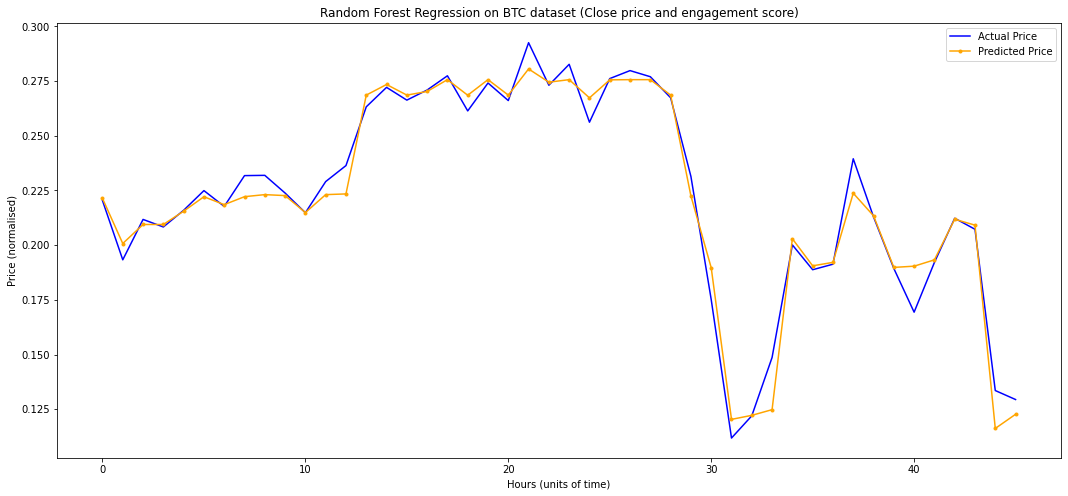

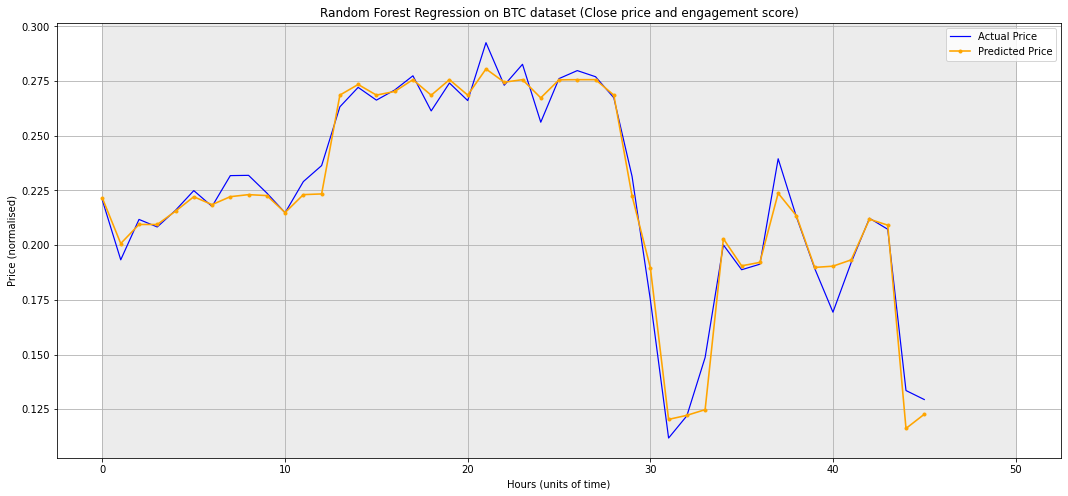

In [37]:
y_test, y_pred, mse, rmse, mae, mape = RandomForestModel(data_scaled)

### Cross Correlation - Random Forest Regression

In [25]:
actual_price_df = pd.DataFrame(y_test, columns=['price'])
predicted_price_df = pd.DataFrame(y_pred, columns=['price'])

# Calculate the Pearson Cross Correlation for lag 0
curr_corr = crosscorr(predicted_price_df['price'], actual_price_df['price'], 
                      method="pearson")
print("Pearson Correlation for lag 0:", curr_corr)

Pearson Correlation for lag 0: 0.9856977523440307


In [10]:
master_df = master_df.append({'script': f'RF_price-{all_title}', 
                                '': '', 
                                '': '', 
                                '': '',
                                'train_p': 60, 
                                '': '',
                                'test_p': 40,
                                '': '', 
                                'mse': round(mse, 4),
                                'rmse': round(rmse, 4),
                                'mae': round(mae, 4),
                                'mape': round(mape, 4), 
                                '': '', 
                                'cross_correlation': curr_corr}, 
                               ignore_index=True)

### SVR prediction

In [12]:
def SVRModel(data_scaled):
  """
  This function takes in a dataframe and predicts the stock price using
  Support Vector Regression model. The function returns the predicted stock
  price and the mean absolute error. It also plots the predicted stock price
  and the actual stock price.
  """
  # split the data into train and test. 
  train_index = int(0.6 * len(data_scaled))
  train = data_scaled[:train_index]
  test = data_scaled[train_index:]
  print("train,test,val",train.shape, test.shape)

  # split the data into features and target.
  xtrain, ytrain = train[:,:2], train[:,1]
  xtest, ytest = test[:,:2], test[:,1]
  X_train = np.zeros((len(xtrain), 2))
  y_train = np.zeros((len(ytrain), 1))
  
  X_test = np.zeros((len(xtest), 2))
  y_test = np.zeros((len(ytest), 1))

  # fill the numpy array with the train data
  for i in range(len(xtrain)):
      X_train[i] = xtrain[i]
      y_train[i] = ytrain[i]
  print("x_train", X_train.shape)
  print("y_train", y_train.shape)

  # fill the numpy array with the test data
  for i in range(len(xtest)):
      X_test[i] = xtest[i]
      y_test[i] = ytest[i]
  print("x_test", X_test.shape)
  print("y_test", y_test.shape)
#   ###############################################################################
  # Create the Support Vector Regression model.
  regressor = SVR(kernel='rbf')#, C=1, gamma='auto')
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)

  rmse = sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)

#   print('Accuracy of the model on training data:', round(regressor.score(X_train, y_train), 2) * 100, '%')
  print('Accuracy of the model on testing data:', round(regressor.score(X_test, y_test), 2) * 100, '%')

  print('Root mean squared error:', round(rmse, 4))
  print('Mean absolute error:', round(mae, 4))
  print('Mean absolute percentage error:', round(mape, 4) * 100, '%')

  # Plot the actual stock price and the predicted stock price.
  plt.figure(figsize=(18, 8))
  plt.plot(y_test, '-', color='blue', label='Actual Price')
  plt.plot(y_pred, '.-', color='orange', label='Predicted Price')
  plt.title('Support Vector Regression on BTC dataset (Close price and engagement score)')
  plt.xlabel('Hours (units of time)')
  plt.ylabel('Price (normalised)')
  plt.legend()
  # plt.gcf().autofmt_xdate()
  plt.show()

  ###############################################################################
  # plot the predicted stock price and the actual stock price on the same graph.
  fig, ax = plt.subplots(figsize=(18, 8))
  ax.plot(y_test, '-', color='blue', label='Actual Price')
  ax.plot(y_pred, '.-', color='orange', label='Predicted Price')
  # add a background to the plot
  ax.axvspan(0, 80, alpha=0.15, color='grey')
  # add a title to the plot
  ax.set_title('Support Vector Regression on BTC dataset (Close price and engagement score)')
  # add a label to the x-axis
  ax.set_xlabel('Hours (units of time)')
  # add a label to the y-axis
  ax.set_ylabel('Price (normalised)')
  # add a legend
  ax.legend()
  # add a grid
  ax.grid()
  plt.show()


  return y_test, y_pred, mse, rmse, mae, mape

train,test,val (109, 2) (73, 2)
x_train (109, 2)
y_train (109, 1)
x_test (73, 2)
y_test (73, 1)
Accuracy of the model on testing data: 98.0 %
Root mean squared error: 0.0219
Mean absolute error: 0.0166
Mean absolute percentage error: 8.05 %


C:\Users\paulc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


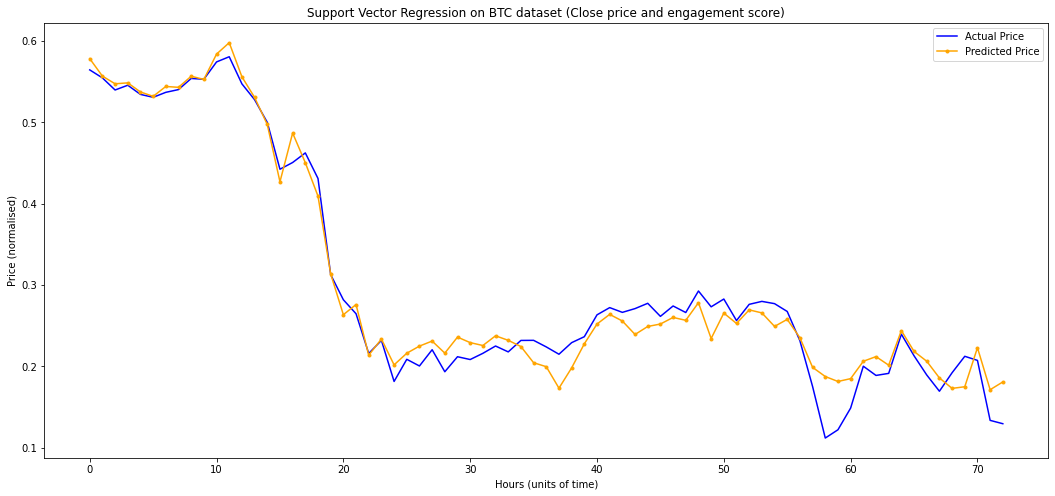

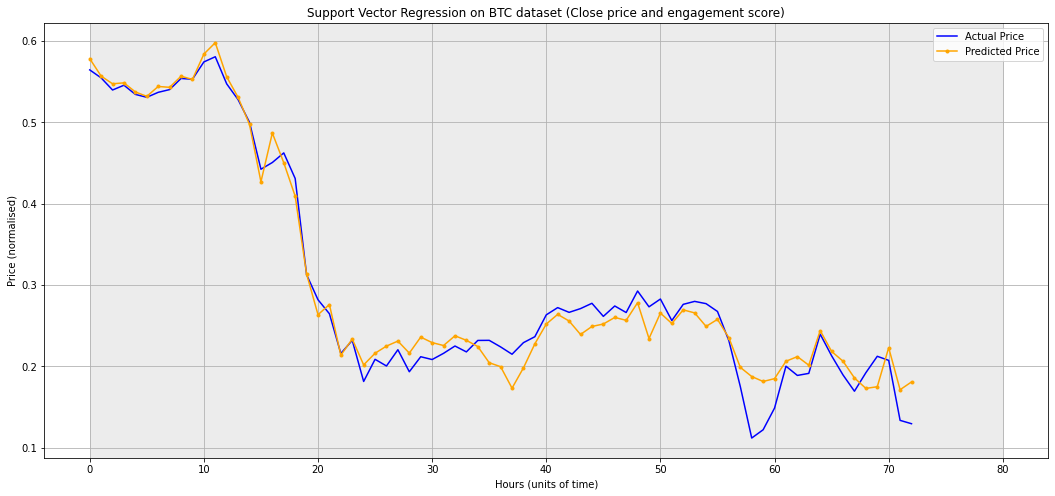

In [13]:
y_test, y_pred, mse, rmse, mae, mape = SVRModel(data_scaled)

### Cross Correlation on SVM

In [14]:
actual_price_df = pd.DataFrame(y_test, columns=['price'])
predicted_price_df = pd.DataFrame(y_pred, columns=['price'])

In [15]:
# Calculate the Pearson Cross Correlation for lag 0
curr_corr = crosscorr(predicted_price_df['price'], actual_price_df['price'], 
                      method="pearson")
print("Pearson Correlation for lag 0:", curr_corr)

Pearson Correlation for lag 0: 0.9876409791445858


In [16]:
master_df = master_df.append({'script': f'SV_price-and-{all_title}', 
                                '': '', 
                                '': '', 
                                '': '',
                                'train_p': 60, 
                                '': '',
                                'test_p': 40,
                                '': '', 
                                'mse': round(mse, 4), 
                                'rmse': round(rmse, 4),
                                'mae': round(mae, 4),
                                'mape': round(mape, 4),
                                '': '', 
                                'cross_correlation': curr_corr}, 
                               ignore_index=True)

### Percentage of tweets (sentiment analysis)

In [18]:
# Create a pie chart to show the percentage of positive and negative sentiment
# positive_sentiment = df_read['positive'].sum()
# negative_sentiment = df_read['negative'].sum()
# neutral_sentiment = df_read['neutral'].sum()

# # Percentage of positive sentiment
# positive_sentiment_percentage = positive_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment) * 100
# negative_sentiment_percentage = negative_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment) * 100
# neutral_sentiment_percentage = neutral_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment) * 100

# # Print the percentage of positive and negative sentiment
# print("\n\n")
# print("Percentage of positive sentiment:", positive_sentiment_percentage)
# print("Percentage of negative sentiment:", negative_sentiment_percentage)
# print("Percentage of neutral sentiment:", neutral_sentiment_percentage)

# # Plot the pie chart 
# labels = 'Positive', 'Negative', 'Neutral'
# sizes = [positive_sentiment_percentage, negative_sentiment_percentage, neutral_sentiment_percentage]
# colors = ['gold', 'yellowgreen', 'lightcoral']
# explode = (0.1, 0, 0)

# plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
# plt.plot()

In [19]:
if os.path.exists('metrics.csv'):
  master_df.to_csv('metrics.csv', mode='a', header=False, index=False)
else:
  master_df.to_csv('metrics.csv', index=False)